# Data loading - check to correctly understand data / label format

NOTE: For this test run on my machine, I put the data in    
- pytorch-3dunet/../data/h5/train  
- pytorch-3duent/../data/h5/val    
it would be even better to also make a folder    
- pytorch-3dunet/../data/h5/test  
- any base data direcotry where you want to keep h5 is fine

The split (60, 10, 2) : (train, val, test) would work, but this is just for testing anyway. Each folder has one h5 per subject, and these h5's in turn each have two datasets: 'raw' and 'label'
  
 ## Plan for notebook 
  
- load data from h5 files, one per subject 
- watch how data changes formats / shapes throughout the training pipeline.
- details:  
 - pytorch always uses the pattern: raw data -> Dataset -> DataLoader, and the DataLoader is in turn fed to the model.
 - when the Dataset object is being created, the original raw volumes are subsampled into many volume patches, on which the model is ultimately trained.

- goal (do in order):  (**Sam copy**)  
   - [x] successfully create train_config  
   - [x] create trainer(train_config)
   - [x] create dataloaders with get_train_dataloaders(config)
   - [x] create model
   - [x] sample raw_data (T1), label_data from dataloader
   - [x] calculate pred = model(raw_data)
   - [ ] call model forward pass and training pass (backprop)  
     
- goal (do in order):  (**Ben copy**)
   - [ ] successfully create train_config  
   - [ ] create trainer(train_config)
   - [ ] create dataloaders with get_train_dataloaders(config)
   - [ ] create model
   - [ ] sample raw_data (T1), label_data from dataloader
   - [ ] calculate pred = model(raw_data)
   - [ ] call model forward pass and training pass (backprop)

In [13]:
import os
import h5py

# standards
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pytorch3dunet
import pytorch3dunet.unet3d as u3  # !
from pytorch3dunet import predict
from pytorch3dunet import train

from pytorch3dunet.unet3d import trainer as trainer
from pytorch3dunet.unet3d.config import _load_config_yaml

from torchsummary import summary
import torch
from torch.utils.data import Dataset, DataLoader


# these lines are required to test dataset / dataloader code from datasets.utils
from pytorch3dunet.unet3d.utils import get_logger, get_class
from pytorch3dunet.datasets.utils import _loader_classes, get_slice_builder, get_train_loaders, get_test_loaders
logger = get_logger('Dataset') 

# convenience
from functools import reduce

In [2]:
os.getcwd()

'/scratch/groups/jyeatman/samjohns-projects/unet3d/pytorch-3dunet/resources'

In [19]:
sam = True  # (False if ben) thinking we could maintain different filepaths here -- or we could copy the whole notebook and maintain two different working notebooks.

if sam:
    
    train_config_filename = 'train_config.yml'
    train_config_fp = '/scratch/groups/jyeatman/samjohns-projects/unet3d/pytorch-3dunet/resources/3DUnet_sulci/train_config.yml'
    
    data_base_fp = '/scratch/groups/jyeatman/samjohns-projects/unet3d/data/h5'
    train_fp = f'{data_base_fp}/train'
    val_fp = f'{data_base_fp}/val'
    
    train_examples = os.listdir(train_fp)
    val_examples = os.listdir(val_fp)

In [87]:
train_config = _load_config_yaml(train_config_fp)
train_config['loss']
# train_config

{'name': 'BCEDiceLoss', 'ignore_index': None, 'skip_last_target': False}

In [21]:
te0 = h5py.File(f'{train_fp}/{train_examples[0]}', 'r')
f'{train_fp}/{train_examples[0]}'

'/scratch/groups/jyeatman/samjohns-projects/unet3d/data/h5/train/108323_PFC_LPC_PMC.h5'

In [22]:
train_h5 = h5py.File(f'{train_fp}/{train_examples[0]}', 'r')

train_h5_raw_np = np.array(train_h5.get('raw'))
train_h5_label_np = np.array(train_h5.get('label'))

raw_shape = train_h5_raw_np.shape
label_shape = train_h5_label_np.shape

raw_shape, label_shape

((1, 256, 256, 256), (102, 256, 256, 256))

In [16]:
# What fraction of a volume is occupied by labels? It's bound to be small.

nvoxels_labeled = train_h5_label_np.sum()
nvoxels_total = reduce(lambda x, y: x*y, train_h5_label_np.shape)
label_fraction = nvoxels_labeled / nvoxels_total
nvoxels_labeled, nvoxels_total, label_fraction

(40940.0, 1711276032, 2.3923668206906786e-05)

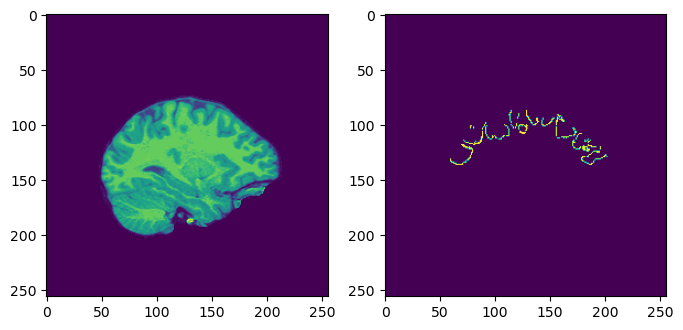

In [21]:
z_slice_at = 100

fig, ax = plt.subplots(1, 2, figsize=(8, 12))
ax[0].imshow(train_h5_raw_np[0, z_slice_at])  # order: Z, Y, X -- slice along Z
ax[1].imshow(train_h5_label_np.sum(axis=0)[z_slice_at]) # Looks good! 

In [79]:
train_config_updated = train_config.copy()

train_config_updated['loaders']['train']['file_paths'] = [train_fp]
train_config_updated['loaders']['val']['file_paths'] = [val_fp]
train_config_updated

dataset_class = _loader_classes('StandardHDF5Dataset')

train_config_updated['loaders']['val']['slice_builder']['threshold'] = 0.00001  # 1e-5
train_config_updated['loaders']['val']['slice_builder']['slack_acceptance'] = 0.000001  # slack acceptance should be lower than threshold

In [80]:
loaders_config = train_config['loaders']

In [81]:
loaders_config

{'num_workers': 8,
 'raw_internal_path': '/raw',
 'label_internal_path': '/label',
 'train': {'file_paths': ['/scratch/groups/jyeatman/samjohns-projects/unet3d/data/h5/train'],
  'slice_builder': {'name': 'FilterSliceBuilder',
   'patch_shape': [128, 128, 128],
   'stride_shape': [40, 40, 40],
   'threshold': 0.01,
   'slack_acceptance': 0.01},
  'transformer': {'raw': [{'name': 'Standardize'},
    {'name': 'RandomFlip'},
    {'name': 'RandomRotate90'},
    {'name': 'RandomRotate',
     'axes': [[2, 1]],
     'angle_spectrum': 45,
     'mode': 'reflect'},
    {'name': 'ElasticDeformation', 'spline_order': 3},
    {'name': 'GaussianBlur3D', 'execution_probability': 0.5},
    {'name': 'AdditiveGaussianNoise', 'execution_probability': 0.2},
    {'name': 'AdditivePoissonNoise', 'execution_probability': 0.2},
    {'name': 'ToTensor', 'expand_dims': False}],
   'label': [{'name': 'RandomFlip'},
    {'name': 'RandomRotate90'},
    {'name': 'RandomRotate',
     'axes': [[2, 1]],
     'angle_sp

In [22]:
# original logic that loads h5 files and makes them into pytorch Dataset objects
# from l. 125 of datasets.hdf5

def create_datasets(cls, dataset_config, phase):
    phase_config = dataset_config[phase]

    # load data augmentation configuration
    transformer_config = phase_config['transformer']
    # load slice builder config
    slice_builder_config = phase_config['slice_builder']
    # load files to process
    file_paths = phase_config['file_paths']
    # file_paths may contain both files and directories; if the file_path is a directory all H5 files inside
    # are going to be included in the final file_paths
    file_paths = cls.traverse_h5_paths(file_paths)

    datasets = []
    for file_path in file_paths:
        try:
            logger.info(f'Loading {phase} set from: {file_path}...')
            dataset = cls(file_path=file_path,
                          phase=phase,
                          slice_builder_config=slice_builder_config,
                          transformer_config=transformer_config,
                          raw_internal_path=dataset_config.get('raw_internal_path', 'raw'),
                          label_internal_path=dataset_config.get('label_internal_path', 'label'),
                          weight_internal_path=dataset_config.get('weight_internal_path', None),
                          global_normalization=dataset_config.get('global_normalization', None))
            datasets.append(dataset)
        except Exception:
            logger.error(f'Skipping {phase} set: {file_path}', exc_info=True)
    return datasets

In [46]:
val_datasets = dataset_class.create_datasets(loaders_config, phase='val')

2023-05-20 20:47:36,649 [MainThread] INFO HDF5Dataset - Loading val set from: /scratch/groups/jyeatman/samjohns-projects/unet3d/data/h5/val/164939_PFC_LPC_PMC.h5...
2023-05-20 20:48:11,698 [MainThread] INFO Dataset - Slice builder config: {'name': 'FilterSliceBuilder', 'patch_shape': [128, 128, 128], 'stride_shape': [40, 40, 40], 'threshold': 1e-05, 'slack_acceptance': 1e-06}
2023-05-20 20:52:03,976 [MainThread] INFO HDF5Dataset - Number of patches: 125
2023-05-20 20:52:03,979 [MainThread] INFO HDF5Dataset - Loading val set from: /scratch/groups/jyeatman/samjohns-projects/unet3d/data/h5/val/959574_PFC_LPC_PMC.h5...
2023-05-20 20:52:38,580 [MainThread] INFO Dataset - Slice builder config: {'name': 'FilterSliceBuilder', 'patch_shape': [128, 128, 128], 'stride_shape': [40, 40, 40], 'threshold': 1e-05, 'slack_acceptance': 1e-06}
2023-05-20 20:56:30,642 [MainThread] INFO HDF5Dataset - Number of patches: 125


In [24]:
# hdf5 -> torch.Tensor logic
# original definition on l. 227 of datasets.utils

def get_test_dataset(config):
    """
    Returns test Dataset.

    :return: Dataset objects
    """

    assert 'loaders' in config, 'Could not find data loaders configuration'
    loaders_config = config['loaders']

    logger.info('Creating test set loaders...')

    # get dataset class
    dataset_cls_str = loaders_config.get('dataset', None)
    if dataset_cls_str is None:
        dataset_cls_str = 'StandardHDF5Dataset'
        logger.warning(f"Cannot find dataset class in the config. Using default '{dataset_cls_str}'.")
    dataset_class = _loader_classes(dataset_cls_str)

    test_datasets = dataset_class.create_datasets(loaders_config, phase='test')
    return test_datasets
    
    
def get_test_loaders(test_datasets, config):
    """ Given a test_dataset, wrap it in a DataLoader and return
        the dataloaders.
    """
    loaders_config = config['loaders']
    num_workers = loaders_config.get('num_workers', 1)
    logger.info(f'Number of workers for the dataloader: {num_workers}')

    batch_size = loaders_config.get('batch_size', 1)
    if torch.cuda.device_count() > 1 and not config['device'].type == 'cpu':
        logger.info(
            f'{torch.cuda.device_count()} GPUs available. Using batch_size = {torch.cuda.device_count()} * {batch_size}')
        batch_size = batch_size * torch.cuda.device_count()

    logger.info(f'Batch size for dataloader: {batch_size}')

    # use generator in order to create data loaders lazily one by one
    for test_dataset in test_datasets:
        logger.info(f'Loading test set from: {test_dataset.file_path}...')
        if hasattr(test_dataset, 'prediction_collate'):
            collate_fn = test_dataset.prediction_collate
        else:
            collate_fn = default_prediction_collate

        yield DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=True,
                         collate_fn=collate_fn)
        
        

In [29]:
train_h5s = sorted(os.listdir(train_fp))
train_h5 = train_h5s[0]

In [27]:
f'{train_fp}/{train_h5}'

'/scratch/groups/jyeatman/samjohns-projects/unet3d/data/h5/train/100206_PFC_LPC_PMC.h5'

In [30]:
import h5py
file = h5py.File(f'{train_fp}/{train_h5}', 'r')

In [70]:
file.keys()

<KeysViewHDF5 ['label', 'raw']>

In [71]:
train_example_label = file['label']
train_example_raw = file['raw']

In [72]:
train_example_label_np = np.array(train_example_label)
train_example_raw_np = np.array(train_example_raw)

In [73]:
train_example_label_np.shape, train_example_raw_np.shape

((8, 256, 256, 256), (1, 256, 256, 256))

In [37]:
val_dir = '/scratch/groups/jyeatman/samjohns-projects/unet3d/data/h5/val'
vals = sorted(os.listdir(val_fp))
val = vals[1]
len(vals), vals

(2, ['164939_PFC_LPC_PMC.h5', '959574_PFC_LPC_PMC.h5'])

In [47]:
dls_train = get_train_loaders(train_config_updated)

2023-05-20 21:09:56,747 [MainThread] INFO Dataset - Creating training and validation set loaders...
2023-05-20 21:09:56,749 [MainThread] WARNING Dataset - Cannot find dataset class in the config. Using default 'StandardHDF5Dataset'.
2023-05-20 21:09:56,753 [MainThread] INFO HDF5Dataset - Loading train set from: /scratch/groups/jyeatman/samjohns-projects/unet3d/data/h5/train/108323_PFC_LPC_PMC.h5...
2023-05-20 21:10:31,454 [MainThread] INFO Dataset - Slice builder config: {'name': 'FilterSliceBuilder', 'patch_shape': [128, 128, 128], 'stride_shape': [40, 40, 40], 'threshold': 0.01, 'slack_acceptance': 0.01}
2023-05-20 21:14:25,181 [MainThread] INFO HDF5Dataset - Number of patches: 2
2023-05-20 21:14:25,184 [MainThread] INFO HDF5Dataset - Loading train set from: /scratch/groups/jyeatman/samjohns-projects/unet3d/data/h5/train/100206_PFC_LPC_PMC.h5...
2023-05-20 21:15:02,044 [MainThread] INFO Dataset - Slice builder config: {'name': 'FilterSliceBuilder', 'patch_shape': [128, 128, 128], 'st

In [50]:
dls_train['train']

In [51]:
di0 = iter(dls_train['train'])
di0_v = iter(dls_train['val'])

x, y = next(di0)  # batch size of 1 -- this is the first dimension apparantly
x.shape, y.shape

(torch.Size([1, 1, 128, 128, 128]), torch.Size([1, 102, 128, 128, 128]))

In [88]:
train_config_updated['trainer']['checkpoint_dir'] = '../checkpoints'
train_config_updated['model']['out_channels'] = 102

train_config_updated['loss'] = {'name': 'BCEDiceLoss', 'ignore_index': None, 'skip_last_target': False}
train_config_updated['eval_metric']['name'] = 'MeanIoU'

In [89]:
train_config_updated

{'model': {'name': 'UNet3D',
  'in_channels': 1,
  'out_channels': 102,
  'layer_order': 'gcr',
  'f_maps': 32,
  'num_groups': 8,
  'final_sigmoid': True},
 'loss': {'name': 'BCEDiceLoss',
  'ignore_index': None,
  'skip_last_target': False},
 'optimizer': {'learning_rate': 0.0002, 'weight_decay': 1e-05},
 'eval_metric': {'name': 'MeanIoU',
  'threshold': 0.4,
  'use_last_target': False,
  'use_first_input': False},
 'lr_scheduler': {'name': 'ReduceLROnPlateau',
  'mode': 'min',
  'factor': 0.5,
  'patience': 30},
 'trainer': {'eval_score_higher_is_better': False,
  'checkpoint_dir': '../checkpoints',
  'resume': None,
  'pre_trained': None,
  'validate_after_iters': 1000,
  'log_after_iters': 500,
  'max_num_epochs': 1000,
  'max_num_iterations': 150000},
 'loaders': {'num_workers': 8,
  'raw_internal_path': '/raw',
  'label_internal_path': '/label',
  'train': {'file_paths': ['/scratch/groups/jyeatman/samjohns-projects/unet3d/data/h5/train'],
   'slice_builder': {'name': 'FilterSlic

In [90]:
trainer = u3.trainer.create_trainer(train_config_updated)

2023-05-20 23:08:00,799 [MainThread] INFO UNetTrainer - Number of learnable params 4084600
2023-05-20 23:08:00,800 [MainThread] INFO Dataset - Creating training and validation set loaders...
2023-05-20 23:08:00,801 [MainThread] WARNING Dataset - Cannot find dataset class in the config. Using default 'StandardHDF5Dataset'.
2023-05-20 23:08:00,805 [MainThread] INFO HDF5Dataset - Loading train set from: /scratch/groups/jyeatman/samjohns-projects/unet3d/data/h5/train/108323_PFC_LPC_PMC.h5...
2023-05-20 23:08:39,717 [MainThread] INFO Dataset - Slice builder config: {'name': 'FilterSliceBuilder', 'patch_shape': [128, 128, 128], 'stride_shape': [40, 40, 40], 'threshold': 0.01, 'slack_acceptance': 0.01}
2023-05-20 23:12:41,525 [MainThread] INFO HDF5Dataset - Number of patches: 2
2023-05-20 23:12:41,528 [MainThread] INFO HDF5Dataset - Loading train set from: /scratch/groups/jyeatman/samjohns-projects/unet3d/data/h5/train/100206_PFC_LPC_PMC.h5...
2023-05-20 23:13:20,511 [MainThread] INFO Dataset

In [91]:
# Create the model
model = u3.model.get_model(train_config['model'])
model

UNet3D(
  (encoders): ModuleList(
    (0): Encoder(
      (basic_module): DoubleConv(
        (SingleConv1): SingleConv(
          (groupnorm): GroupNorm(1, 1, eps=1e-05, affine=True)
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (ReLU): ReLU(inplace=True)
        )
        (SingleConv2): SingleConv(
          (groupnorm): GroupNorm(8, 16, eps=1e-05, affine=True)
          (conv): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (ReLU): ReLU(inplace=True)
        )
      )
    )
    (1): Encoder(
      (pooling): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (basic_module): DoubleConv(
        (SingleConv1): SingleConv(
          (groupnorm): GroupNorm(8, 32, eps=1e-05, affine=True)
          (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (ReLU): ReLU(inplace=True)
        )
     

# Test model can do a minimal forward pass

In [93]:
x.shape

torch.Size([1, 1, 128, 128, 128])

In [94]:
pred = model(x)
pred.shape

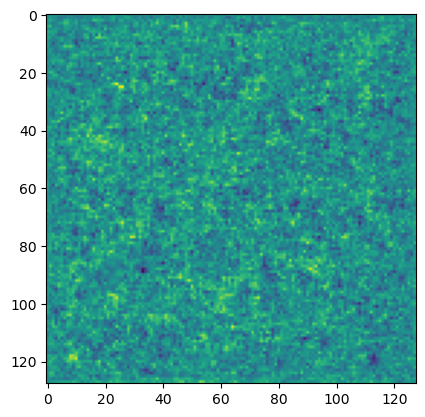

In [100]:
pred_np = pred.detach().numpy() # convert back to numpy for easy visualization
plt.imshow(pred_np[0, 0, 100])

In [102]:
tl = trainer.loaders['train']
ti = iter(tl)
t = next(ti)

In [103]:
input, target, weight = trainer._split_training_batch(t)

In [104]:
input.shape, target.shape, weight

(torch.Size([1, 1, 128, 128, 128]), torch.Size([1, 102, 128, 128, 128]), None)

# Test model training

In [105]:
# forward pass -- as implemented by trainer class actually used in train loop
output, loss = trainer._forward_pass(input, target, weight)
output.shape

torch.Size([1, 102, 128, 128, 128])

In [107]:
trainer.optimizer.zero_grad()
loss.backward()
trainer.optimizer.step()

# If the cell above runs for you, congratulations!

This should be enough to check that the training loop won't fail for silly reasons like mismatch of tensor dimensions, empty datasets, etc.  
  
# Fin